In [1]:
import pandas as pd
import numpy as np

# Outil de geometrie.geographie
import geopandas as gpd
import json 
from shapely.geometry import shape, Point
import shapely
from vincenty import vincenty

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import folium

from sklearn import preprocessing

# Option d'affchage
pd.set_option('display.max_columns', None)

In [2]:
# Importation de la base
df0 = pd.read_csv('data/valeursfoncieres-2019.txt', sep = '|')

# Copie de la base
df1 = df0.copy()

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# I. Nettoyage de la base de données

In [3]:
# Découverte de la base

df1.sample(3)

Code service CH  Reference document  1 Articles CGI  2 Articles CGI  \
752405               NaN                 NaN             NaN             NaN   
1224828              NaN                 NaN             NaN             NaN   
1610775              NaN                 NaN             NaN             NaN   

         3 Articles CGI  4 Articles CGI  5 Articles CGI  No disposition  \
752405              NaN             NaN             NaN               1   
1224828             NaN             NaN             NaN               1   
1610775             NaN             NaN             NaN               1   

        Date mutation Nature mutation Valeur fonciere  No voie B/T/Q  \
752405     09/05/2019           Vente        25000,00      NaN   NaN   
1224828    29/03/2019           Vente       230000,00     11.0   NaN   
1610775    18/11/2019           Vente       384000,00     26.0   NaN   

        Type de voie Code voie                        Voie  Code postal  \
752405           NaN      B027                    LE MAYNE      33350.0   
1224828          RUE      0360  DU COMMERCE (CHEMILLE MELA      49120.0   
1610775          CHE      1145                 DES PECHERS      63200.0   

                   Commune Code departement  Code commune  Prefixe de section  \
752405      SAINTE-COLOMBE               33           390                 NaN   
1224828  CHEMILLE-EN-ANJOU               49            92                 NaN   
1610775               RIOM               63           300                 NaN   

        Section  No plan No Volume 1er lot Surface Carrez du 1er lot 2eme lot  \
752405        A     1106       NaN     NaN                       NaN      NaN   
1224828      AH      116       NaN     NaN                       NaN      NaN   
1610775      ZB      756       NaN     NaN                       NaN      NaN   

        Surface Carrez du 2eme lot 3eme lot Surface Carrez du 3eme lot  \
752405                         NaN      NaN                        NaN   
1224828                        NaN      NaN                        NaN   
1610775                        NaN      NaN                        NaN   

         4eme lot Surface Carrez du 4eme lot  5eme lot  \
752405        NaN                        NaN       NaN   
1224828       NaN                        NaN       NaN   
1610775       NaN                        NaN       NaN   

        Surface Carrez du 5eme lot  Nombre de lots  Code type local  \
752405                         NaN               0              NaN   
1224828                        NaN               0              2.0   
1610775                        NaN               0              1.0   

          Type local  Identifiant local  Surface reelle bati  \
752405           NaN                NaN                  NaN   
1224828  Appartement                NaN                 93.0   
1610775       Maison                NaN                160.0   

         Nombre pieces principales Nature culture Nature culture speciale  \
752405                         NaN              P                     NaN   
1224828                        3.0              S                     NaN   
1610775                        4.0              S                     NaN   

         Surface terrain  
752405             929.0  
1224828            512.0  
1610775            532.0

## I.1. Séléction des lignes et colonnes intéressantes pour le projet

### Sélection des colonnes

In [4]:
# Affichage des différentes colonnes

df1.columns

Index(['Code service CH', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='object')

In [5]:
# Sélection des colonnes

df = df1[[
        'Date mutation', 'Nature mutation', 'Valeur fonciere',
        'No voie', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
        'Commune', 'Code departement', 'Code commune', 'Type local',
        'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain',
        'Section', 'No plan'
        ]]

### Sélection des lignes

In [6]:
# Premier tri sur les lignes 

df = df[df['Nature mutation'] == 'Vente']
df = df[df['Code departement'] == 75]
df = df[df['Type local'] == 'Appartement']

### Changement du nom des variables

In [7]:
df = df[[
        'Date mutation', 'Valeur fonciere', 'No voie', 
        'Type de voie', 'Voie', 'Code postal', 'Surface reelle bati', 
        'Nombre pieces principales',
        'Code departement', 'Code commune', 'Code voie',
        'Type local', 'Section', 'No plan'
        ]]

df = df.rename(columns = {
                            'Date mutation': 'Date', 
                            'Valeur fonciere': 'Valeur',
                            'Type de voie': 'TypeVoie',
                            'No voie': 'Numero',
                            'Code postal': 'CodePostal',
                            'Surface reelle bati': 'Surface',
                            'Nombre pieces principales': 'NbPieces',
                            'Surface terrain': 'SurfaceTerrain',
                            'Code departement': 'Code_departement', 
                            'Code commune': 'Code_commune', 
                            'Code voie': 'Code_voie',
                            'Type local': 'TypeLocal',
                            'No plan': 'No_plan'
                         }
              )

## I.2. Gestion des variables

### I.2.1 Variables existantes

In [8]:
df.dtypes

Date                 object
Valeur               object
Numero              float64
TypeVoie             object
Voie                 object
CodePostal          float64
Surface             float64
NbPieces            float64
Code_departement     object
Code_commune          int64
Code_voie            object
TypeLocal            object
Section              object
No_plan               int64
dtype: object

On remarque que la variable "Valeur" n'est pas de type float ou int, il va falloir y remédier !

### Valeur

In [9]:
# Les biens dont la valeur n'est pas renseignée ne nous intéressent pas

df = df.dropna(subset = ['Valeur'])

# Changement des virgules en point pour pouvoir convertir les types str en types float

df['Valeur'] = df.apply(lambda row : str(row.Valeur).replace(',', '.'), axis = 1)
df['Valeur'] = pd.to_numeric(df['Valeur'])

# On divise par 1000 les prix pour plus de lisibilité

df['Valeur'] = df['Valeur'] / 1000

# On se concentre sur une tranche de prix "raisonnable"

df = df[df['Valeur'] > 60]
df = df[df['Valeur'] < 15000]

# Pour déterminer ces bornes, nous sommes allé sur des sites d'immobiliers à Paris pour 
# trouver les valeurs extrêmes

### Surface

D'après la loi, un logement mis en location doit respecter une surface minimum. Il s'agit d'un des critères de décence du logement.

Le logement doit comporter au moins une pièce principale présentant :

une surface habitable de 9 m² et une hauteur sous plafond minimale de 2,20 mètres,
ou un volume habitable de 20 m³.

In [10]:
# On trie en conséquence

df = df[df['Surface'] >= 9]

### Date

In [11]:
display(df.sort_values('Date')[['Date']].head())
df[pd.isna(df['Date'])].shape

# Il ne semble pas y avoir de valeurs manquantes

Date
2507781  01/02/2019
2496220  01/02/2019
2496216  01/02/2019
2526061  01/02/2019
2496195  01/02/2019

(0, 14)

### Elements d'adresse (Numero, TypeVoie,  Voie, CodePostal)

In [12]:
# Numero

print(df[pd.isna(df['Numero'])].shape)

# Tous les appartments ont un numéro indiqué. On est satisfait car on souhaite une localisation précise des appartements

(0, 14)


In [13]:
# TypeVoie

print(df[pd.isna(df['TypeVoie'])].shape)

# 15 valeurs manquantes, on regarde à quoi elles correspondent

display(df[pd.isna(df['TypeVoie'])].sample(3))

# Cela correspond à des adresses où le type de voie est spécial (Villa, Pont, Autoroute, Rond point) 
# et est contenu dans la variable Voie
# On laisse comme ca pour l'instant

(15, 14)


Date  Valeur  Numero TypeVoie                        Voie  \
2527197  27/03/2019   731.4     4.0      NaN                        Z 20   
2500112  03/07/2019   217.0     4.0      NaN        ALLEE DES HORTENSIAS   
2501436  14/02/2019   339.7     3.0      NaN  VLA HONORE GABRIEL RIQUETI   

         CodePostal  Surface  NbPieces Code_departement  Code_commune  \
2527197     75020.0     85.0       4.0               75           120   
2500112     75014.0     18.0       1.0               75           114   
2501436     75015.0     31.0       1.0               75           115   

        Code_voie    TypeLocal Section  No_plan  
2527197      X670  Appartement      AT       11  
2500112      R072  Appartement      CW       47  
2501436      4648  Appartement      FX        5

In [14]:
# Voie

display(df.sort_values('Voie')[['Voie']].head())
print(df[pd.isna(df['Voie'])].shape)

# Il ne semble pas y avoir de valeurs manquantes

Voie
2493978             A 11
2532159            AB 20
2528149            AB 20
2494739             ABEL
2497022  ABEL HOVELACQUE

(0, 14)


In [15]:
# CodePostal

print(df[pd.isna(df['CodePostal'])].shape)

# 1 valeur manquante, on regarde à quoi elle correspond

display(df[pd.isna(df['CodePostal'])])

# La rue de l'Abbé Groult se situe dans le 15ème, on remplit à la main.

df.at[2503844, 'CodePostal'] = float(75015)

display(df.loc[[2503844]])

(1, 14)


Date  Valeur  Numero TypeVoie              Voie  CodePostal  \
2503844  23/05/2019   150.0    23.0      RUE  DE L ABBE GROULT         NaN   

         Surface  NbPieces Code_departement  Code_commune Code_voie  \
2503844     19.0       1.0               75           115      0012   

           TypeLocal Section  No_plan  
2503844  Appartement      BQ       16

Date  Valeur  Numero TypeVoie              Voie  CodePostal  \
2503844  23/05/2019   150.0    23.0      RUE  DE L ABBE GROULT     75015.0   

         Surface  NbPieces Code_departement  Code_commune Code_voie  \
2503844     19.0       1.0               75           115      0012   

           TypeLocal Section  No_plan  
2503844  Appartement      BQ       16

### NbPieces (nombre de pièces)

In [16]:
print(df[pd.isna(df['NbPieces'])].shape)

display(df.sort_values('NbPieces')[['NbPieces']].head(3))

# Pas de valeurs manquantes mais des appartements à 0 pièces...

display(df[df['NbPieces'] == 0].head(3))

# Les entrées n'ont pas l'air des anomalies, la valeur doit être manquante.
# On laisse tel quel en gardant à l'esprit cette observation

(0, 14)


NbPieces
2523126       0.0
2513217       0.0
2534129       0.0

Date  Valeur  Numero TypeVoie             Voie  CodePostal  \
2479736  17/06/2019  346.75    10.0      RUE  SAINTE ANASTASE     75003.0   
2480202  12/07/2019  120.00    17.0       BD     SAINT MARTIN     75003.0   
2480249  02/07/2019  342.50    22.0      RUE      DE PICARDIE     75003.0   

         Surface  NbPieces Code_departement  Code_commune Code_voie  \
2479736     29.0       0.0               75           103      8531   
2480202     18.0       0.0               75           103      8692   
2480249     12.0       0.0               75           103      7395   

           TypeLocal Section  No_plan  
2479736  Appartement      AL      106  
2480202  Appartement      AF        8  
2480249  Appartement      AH       10

### I.2.2 Création de variables

In [17]:
# Prix au m2

df['prixm2'] = df['Valeur'] / df['Surface']

In [18]:
# Création de la variable 'id' qui permettra d'identifier l'adresse précise dans une autre bdd

In [19]:
def code_numero(numero):
    """Créé le code utilisé pour identifier le numero d'une rue au sein du code 'id' 

    Argument :
    numero : float
        numero de la rue tel que présent dans la base de données

    Return :
    code : str
        Le code correspondant (format 00007 pour le numéro 7 d'une rue, par exemple)
    """

    code = str(int(numero))
    code = '0' * (5 - len(code)) + code

    return code

df['id'] = df['Code_departement'].astype(str) + df['Code_commune'].astype(str) + '_' + df['Code_voie'].astype(str) + '_' + df['Numero'].apply(code_numero)

df = df.drop(columns = ['Code_commune', 'Code_departement', 'Code_voie'])

# Vérification

df.head(3)

Date   Valeur  Numero TypeVoie         Voie  CodePostal  \
2478017  04/01/2019  1196.00    17.0      RUE       DUPHOT     75001.0   
2478018  03/01/2019  1570.49    13.0      RUE  DE THORIGNY     75003.0   
2478022  10/01/2019   230.00     4.0      RUE      BLONDEL     75003.0   

         Surface  NbPieces    TypeLocal Section  No_plan     prixm2  \
2478017    112.0       3.0  Appartement      BC       14  10.678571   
2478018    104.0       3.0  Appartement      AL       15  15.100865   
2478022     26.0       1.0  Appartement      AB      130   8.846154   

                       id  
2478017  75101_2999_00017  
2478018  75103_9298_00013  
2478022  75103_1021_00004

In [20]:
# Petite sauvegadre de la base à ce stade

dfv0 = df.copy()

## I.3. Choix de la variable à prédir

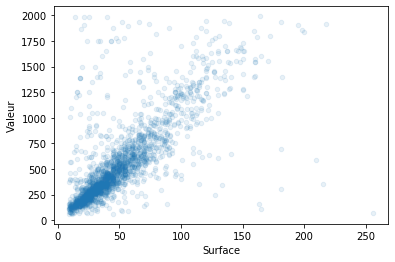

In [21]:
# On peut tracer le prix en fonction de la surface

df[df['Valeur'] < 2000].sample(2000).plot(x = 'Surface', y = 'Valeur', kind = 'scatter', alpha = .1)

# On a tracé le graphe pour les appartements ayant un prix inférieur à 2 millions

In [22]:
df[df['Valeur'] < 2000]['Valeur'].corr(df[df['Valeur'] < 2000]['Surface'])

0.723571040247899

On voit une relation linéaire apparaitre, justifiée par un coefficient de corrélation significatif, de 0.72 

#### On fait donc l'hypothèse qu'il y a une corélation linéaire entre le prix d'un appartement et sa surface en m2.
#### On se donnera donc pour objectif de prédir le prix au m2 d'un appartement en fonction de différents paramètres.

## I.4. Gestion des anomalies

La base de données n'est pas parfaite, certaines entrées sont erronées.
La premier nettoyage que nous allons faire, qui est aussi le plus grossier, est de se restreindre à des prix au m2 raisonnables.  
Le site meilleursagents.com recense les prix au m2 de nombreux appartements à Paris.  
Les prix les plus bas observé sont environ de 4 700 €/m2  
Les prix les plus hauts observés sont environ de 32 000 €/m2

#### On choisit donc de considérer les biens dont le prix au m2 est compris entre 4 230 € et 35 200 (marge de 10%)

In [23]:
# Sélection de la tranche de prix choisie

df = df[df['prixm2'] > 4.23]
df = df[df['prixm2'] < 35.2]

0.8711435007412439

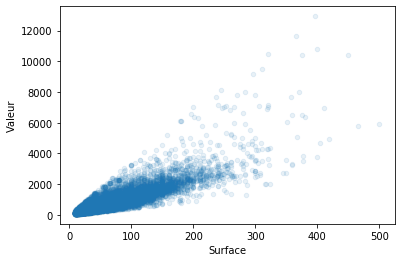

In [24]:
df.plot(x = 'Surface', y = 'Valeur', kind = 'scatter', alpha = .1)

df['Valeur'].corr(df['Surface'])

On obtiens donc un "cône" de données, et le coefficient de corrélation n'en est que renforcé : 0.87

# II. Enrichissement de la base

## II.1 Couplage : date de construction du bâtis

Pour obtenir la date de construction des immeubles, on utilise deux nouvelles bases :  
  
   -df_dates qui donne la date de construction à partir d'un identificateur id2  
   -df_join qui associe l'identificateur id2 à une adresse
    
   df_join va donc nous permettre de faire la jointure entre la base d'origine et la base df_dates pour obtenir la date deconstruction des immeubles.

In [25]:
# Importation des bases

df_dates = pd.read_csv('data/date_construction.csv', sep = ',')
df_join = pd.read_csv('data/PARCELLE_CADASTRALE.csv', sep = ',')

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
# On garde que les variables qui nous sont utiles ici

df_join = df_join[['n_sq_pc', 'c_sec', 'n_pc']]
df_dates = df_dates[['n_sq_pc', 'c_perconst']]

In [27]:
# On regroupe les deux bases grâce à l'identificateur

df_dates = df_dates.merge(df_join, left_on = 'n_sq_pc', right_on = 'n_sq_pc')
df_dates = df_dates.drop(columns = ['n_sq_pc'])

In [28]:
# On crée l'identificateur dans la base d'origine et le fait correspondre avec celui de la base des dates

df['id2'] = df.apply(lambda row: str(row.Section) + str(row.No_plan), axis = 1)
df_dates['id2'] = df_dates.apply(lambda row: str(row.c_sec) + str(row.n_pc), axis = 1)
df_dates = df_dates.drop_duplicates(subset = ['id2'], keep = 'first')

display(df_dates.head(3))
display(df.head(3))


# On joint les deux bases

df = pd.merge(df, df_dates, on = 'id2')

c_perconst c_sec  n_pc   id2
0         5.0    FX    57  FX57
1         3.0    EF     1   EF1
3         3.0    BT    61  BT61

Date   Valeur  Numero TypeVoie         Voie  CodePostal  \
2478017  04/01/2019  1196.00    17.0      RUE       DUPHOT     75001.0   
2478018  03/01/2019  1570.49    13.0      RUE  DE THORIGNY     75003.0   
2478022  10/01/2019   230.00     4.0      RUE      BLONDEL     75003.0   

         Surface  NbPieces    TypeLocal Section  No_plan     prixm2  \
2478017    112.0       3.0  Appartement      BC       14  10.678571   
2478018    104.0       3.0  Appartement      AL       15  15.100865   
2478022     26.0       1.0  Appartement      AB      130   8.846154   

                       id    id2  
2478017  75101_2999_00017   BC14  
2478018  75103_9298_00013   AL15  
2478022  75103_1021_00004  AB130

In [29]:
# Et on nettoie le tout

df = df.drop(columns = ['id2', 'Section', 'No_plan'])
df = df.rename(columns = {'c_perconst': 'periode_construction'})

In [30]:
px.histogram(df.sample(10000), x = 'periode_construction')

In [31]:
# La catégorie 4 n'existe pas, on recode pour que ca soit plus compréhensif

def ajustement(valeur):
    
    if valeur in [i for i in range(5, 13)]:
        return valeur - 1
    
    elif valeur == 99:
        return 0
    
    else:
        return valeur

df['periode_construction'] = df.apply(lambda row: ajustement(row.periode_construction), axis = 1)

In [32]:
px.histogram(df.sample(1000), x = 'periode_construction')

On obtient ici plusieurs tranches de périodes de constructions.
D'après la documentation de la base :  
0 : Données manquantes  
1 : Avant 1800	
2 : 1801-1850	
3 : 1851-1914	
4 : 1915-1939	
5 : 1940-1967	
6 : 1968-1975	
7 : 1976-1981	
8 : 1982-1989	
9 : 1990-1999	
10 : 2000-2007	
11 : 2008 et plus

### *A partir de maintenant, les exemples seront faits sur une petite portion de la base, pour éviter les calculs trop longs.*
### *La base a été traitée en entier par nos soins en amont, puis sauvegardée*

In [33]:
df = df.sample(100)
df_traitee = pd.read_csv('data/données_calculees.csv')

## II.2 Ajout de la variable arrondissement

In [34]:
df['Arrondissement'] = df.apply(lambda row: int(str(int(row.CodePostal))[3:5]), axis = 1)

## II.3 Couplage avec la base de données GPS

On souhaite obtenir les coordonnées GPS de tous les appartements présents dans la base.
Pour cela, nous avons trouvé une base de données qui répertorie toutes les adresses parisiennes et leur associe des coordonnées GPS.
Pour coupler les deux bases, nous utiliserons la variable id précedemment crée.
Ce code id est de la forme WWXXX_YYYY_ZZZZZ avec : 	
##### WW est le code département (75 ici)
##### XXX est le code commune (115 pour le 15ème arrondissement)
##### YYYY est le code voie (4903 pour l'avenue Jean Jaurès par exemple)
##### ZZZZ est le numéro (00005 pour le 5)


In [35]:
df2 = pd.read_csv('data/gps.csv', sep = ';')

In [36]:
df2[df2['id'].str[:2] == '75'].sample(3)

Unnamed: 0                id  id_fantoir  numero  rep  \
33662        33662  75118_7755_00009  75118_7755       9  NaN   
138433      138433  75105_6581_00063  75105_6581      63  NaN   
118526      118526  75111_8208_00067  75111_8208      67  NaN   

                        nom_voie  code_postal  code_insee  \
33662              Rue du Poteau        75018       75118   
138433            Rue Mouffetard        75005       75105   
118526  Boulevard Richard Lenoir        75011       75111   

                     nom_commune  code_insee_ancienne_commune  \
33662   Paris 18e Arrondissement                          NaN   
138433   Paris 5e Arrondissement                          NaN   
118526  Paris 11e Arrondissement                          NaN   

        nom_ancienne_commune          x           y       lon        lat  \
33662                    NaN  651830.87  6866098.30  2.343042  48.893090   
138433                   NaN  652278.31  6860482.82  2.349775  48.842625   
118526                   NaN  653925.60  6862455.43  2.372005  48.860484   

        alias  nom_ld libelle_acheminement                 nom_afnor  \
33662     NaN     NaN                PARIS             RUE DU POTEAU   
138433    NaN     NaN                PARIS            RUE MOUFFETARD   
118526    NaN     NaN                PARIS  BOULEVARD RICHARD LENOIR   

       source_position source_nom_voie  
33662          commune         commune  
138433         commune         commune  
118526         commune         commune

### Séléction des variables utiles

In [37]:
df_GPS = df2[[
        'id', 'lon', 'lat', 
        ]]

### Couplage avec df

In [38]:
df = df.merge(df_GPS, left_on = 'id', right_on = 'id')
df.sample(3)

Date   Valeur  Numero TypeVoie             Voie  CodePostal  \
39  24/01/2019  346.354    18.0      RUE       DE SEVIGNE     75004.0   
93  27/12/2019  415.000    32.0      RUE          LANTIEZ     75017.0   
89  27/06/2019  308.900     8.0      RUE  GUSTAVE ROUANET     75018.0   

    Surface  NbPieces    TypeLocal     prixm2                id  \
39     30.0       1.0  Appartement  11.545133  75104_8953_00018   
93     38.0       2.0  Appartement  10.921053  75117_5329_00032   
89     29.0       2.0  Appartement  10.651724  75118_4426_00008   

    periode_construction c_sec  n_pc  Arrondissement       lon        lat  
39                   3.0    AN    47               4  2.362496  48.856169  
93                   7.0    DN   158              17  2.324065  48.895155  
89                   3.0    AY    66              18  2.340083  48.896445

On peut donc maintenant représenter les appartements dans un plan de Paris.

In [39]:
map_osm = folium.Map(location = [48.853332, 2.348776], tiles = 'CartoDB dark_matter', zoom_start = 12.2)

df_print = df_traitee.sample(1000)

paliers = np.linspace(min(df_print['prixm2']), max(df_print['prixm2']), 10)

for i in range(9):
    df_pal = df_print[df_print['prixm2'] < paliers[i + 1]]
    df_pal = df_print[df_print['prixm2'] > paliers[i]]
    couleur = 'rgb(' + str(255) + ',' + str(255 * (10 - i) / 10) + ',' + str(0) + ')'

    for lat, lon in [(row.lat, row.lon) for _, row in df_pal.iterrows()]:
        map_osm.add_child(folium.CircleMarker(location = [lat, lon], radius = 1, color = couleur))
    
map_osm

In [40]:
px.scatter(
        df_traitee, 
        x = 'lon', 
        y = 'lat', 
        color = 'prixm2', 
        template = 'none', 
        color_continuous_scale = 'Jet', 
        opacity = .2
            )

On constate bien les faits stylisé déjà connu : 
#### Les quartiers périphériques sont en général moins chers que les quartiers centraux.
#### Les quartiers de l'ouest sont plus chers que ceux à l'est.

## II.4 Ajout de la variable du Quartier administatif


In [41]:
# Importation de la base des quartiers

df_quartier = pd.read_csv('data/quartier_paris.csv', sep = ';')

In [42]:
# Sélection des variables utiles

df_quartier = df_quartier[['c_qu', 'geom']]

# Traitement avec geopandas

df_quartier['geom'] = df_quartier.apply(lambda row: json.loads(row.geom), axis = 1)
geom = [shape(i) for i in df_quartier['geom']]
df_quartier['geom'] = gpd.GeoDataFrame({'geometry':geom})['geometry']

In [43]:
def determine_quartier(lat, lon):
    """
    Cette fonction détermine le quartier administratif d'un appartement en fonction de ses
    coordonnées GPS
    """
    
    for _, row in df_quartier.iterrows():
        
        polygon = row.geom
        
        if polygon.contains(Point(lon, lat)):
            return row.c_qu
        
    return 0

In [44]:
# Ajout de la variable

df['Quartier'] = df.apply(lambda row: determine_quartier(row.lat, row.lon), axis = 1)

## II.5 Ajout du score de proximité aux espaces verts

In [45]:
# Importation de la base des espaces verts

df_jardin = pd.read_csv('data/espaces_verts.csv', sep = ';')

In [46]:
# Sélection des catégories utiles

df_jardin = df_jardin[df_jardin['Catégorie'].isin(['Square', 'Jardin', 'Pelouse', 'Parc', 'Bois'])]

In [47]:
# On renome les variables

df_jardin = df_jardin[[
        'Superficie totale réelle', 'Geo Shape', 
        '''Nom de l'espace vert''']].rename(columns = {
                                        'Superficie totale réelle' : 'Aire',
                                        'Geo Shape' : 'geom',
                                        '''Nom de l'espace vert''' : 'Nom'
                                                        }
                                            )
df_jardin = df_jardin.reset_index()

In [48]:
# Traitement avec geoapndas

df_jardin['geom'] = df_jardin.apply(lambda row: json.loads(str(row.geom)), axis = 1)
geom = [shape(i) for i in df_jardin['geom']]
df_jardin['geom'] = gpd.GeoDataFrame({'geometry':geom})['geometry']
df_jardin = df_jardin.dropna(subset=['Aire'])

In [49]:
# Standardisation des aires des jardins

pt = preprocessing.PowerTransformer(method='box-cox', standardize = False)
df_jardin[['Aire']] = pt.fit_transform(df_jardin[['Aire']])

min_max_scaler = preprocessing.MinMaxScaler()
df_jardin[['Aire']] = min_max_scaler.fit_transform(df_jardin[['Aire']])

In [50]:
def calcule_score_jardin(lat, lon):
    """
    Le score se calcule ainsi : score = sqrt(aire du jardin le plus proche) / distance à ce jardin
    """
    L = []
    for _, row in df_jardin.iterrows():

        polygon = row.geom

        distance = polygon.distance(Point(lon, lat))
        L.append((distance, row.Aire))
        
    L = sorted(L, key = lambda x:  x[0])
    (distance, aire) = L[0]
    score = np.sqrt(aire) / (distance * 111) # On multiplie par 111 pour convertir la distance en degré en metres
    
    return score

In [51]:
df['score_jardin'] = df.apply(lambda row: calcule_score_jardin(row.lat, row.lon), axis = 1)

## II.6 Ajout du score de proximité aux monuments

In [52]:
# Importation de la base des monuments

df_monuments = pd.read_csv('data/monuments.csv', sep = ';')

In [53]:
# On standardise le nombre de visiteurs

df_monuments['visiteurs']/=max(df_monuments['visiteurs'])

### Calcul du score de proximité aux monuments

In [54]:
def calcule_scores_monument(lat,lon):

    distances_aux_monuments = []

    for i,row in df_monuments.iterrows():
        distances_aux_monuments.append((row.nom, row.visiteurs, vincenty((row.lat, row.lon), (lat, lon))))

    try:
        score_1 = max([monument[1] for monument in distances_aux_monuments if monument[2] < 1])
    except:
        score_1 = 0

    try:
        score_2 = sum([monument[1]/monument[2] for monument in distances_aux_monuments if monument[2] < 3])
    except:
        score_2 = 0

    return (score_1, score_2)

In [55]:
# Calcul des scores

L1, L2 = [], []

for _, row in df.iterrows():
    (a,b) = calcule_scores_monument(row.lat, row.lon)
    L1.append(a)
    L2.append(b)

In [56]:
# Calcul du score final

df['score_1'], df['score_2'] = L1, L2
df['score_2'] /= max(df['score_2'])
df['score_monument'] = ( (1/5) * df['score_1'] + (4/5) * df['score_2'] ) 
df = df.drop(columns = ['score_1', 'score_2'])

## II.7 Ajout du score de proximité aux stations de métro

### II.7.1 Traitement de la base des stations parisiennes

In [57]:
#Importation de la base

df_metro = pd.read_csv('data/stations_metro.csv', sep = ';')

In [58]:
#On garde les colonnes et les lignes qui nous intéressent

df_metro = df_metro[[
        'Geo Point', 'nomlong', 'reseau',
                    ]]

df_metro = df_metro.where(df_metro['reseau'] == 'METRO').dropna()
df_metro.sample(3)

Geo Point            nomlong reseau
475  48.8510502823,2.34427334542  CLUNY-LA-SORBONNE  METRO
467  48.8334508582,2.33174013099  DENFERT-ROCHEREAU  METRO
928  48.9060940502,2.33183083796          GARIBALDI  METRO

Problème, la variable Geo Point doit être traitée pour obtenir la latitude et la longitude

In [59]:
#Fonctions de traitement des coordonnées 

def sepvirgulex(s):
    i = 0
    while s[i] != ',':
        i+=1
        
    x = float(s[:i])
    
    return x

def sepvirguley(s):
    i = 0
    while s[i] != ',':
        i+=1
        
    y = float(s[i+1:])
    
    return y

In [60]:
# Crétaion des variables de lattitude et longitude à partir de la variables des coordonnées

df_metro['lat'] = df_metro['Geo Point'].apply(sepvirgulex)
df_metro['lon'] = df_metro['Geo Point'].apply(sepvirguley)

df_metro = df_metro[['nomlong','reseau','lon','lat']].rename(columns = {
                                                            'nomlong': 'Station', 
                                                                         }
                                                            )

df_metro.sample(3)

Station reseau       lon        lat
738  PLACE DES FETES  METRO  2.393056  48.876806
960     POISSONNIERE  METRO  2.349294  48.877236
486     MONTPARNASSE  METRO  2.324397  48.843781

### II.7.1 Traitement de la base donnant la frequentation des stations

In [61]:
#Importation de la base 

df_metro_pop = pd.read_csv('data/trafic_metro.csv', sep = ";")

In [62]:
# On retient les colonnes et les lignes qui nous intéressent

df_metro_pop = df_metro_pop[['Rang','Station','Réseau','Trafic']].rename(columns = {'Réseau' : 'Reseau'})
df_metro_pop = df_metro_pop.where(df_metro_pop['Reseau'] == 'Métro').dropna()

In [63]:
# Traitement du nom des stations pour qu'ils collent entre les deux bases

def sansparenthese(s):
    for i in range(len(s)):
        if s[i] == '(':
            
            return s[:i]
        
    return s

def sanstiret(s):
    for i in range(len(s)):
        if s[i]=='-':
            s = s[:i] + ' ' + s[i+1:]
            
    return s

def sansespace(s):
    if s[-1] != ' ':
        
        return s
    else:
        
        return sansespace(s[:-1])

def sansrer(s):
    if s[-4:]== ' RER':
        return s[:-4]
    
    return s

df_metro['Station'] = df_metro['Station'].apply(sanstiret)
df_metro['Station'] = df_metro['Station'].apply(sansparenthese)
df_metro['Station'] = df_metro['Station'].apply(sansespace)
df_metro['Station'] = df_metro['Station'].apply(sansrer)

df_metro = df_metro.replace([
    'LES COURTILLES ASNIERES GENNEVILLIERS', 'BOBIGNY PANTIN', 'SAINT MANDE', 'LOUVRE RIVOLI', 
    'MALAKOFF RUE ÉTIENNE DOLET', 'LA DEFENSE GRANDE ARCHE', 'BIBLIOTHEQUE FRANCOIS MITTERRAND', 
    'LES AGNETTES ASNIERES GENNEVILLIERS', 'PALAIS ROYAL MUSEE DU LOUVRE', "CHAUSSEE D'ANTIN", 
    'AUBERVILLIERS PANTIN', 'PLACE DE CLICHY', 'PEREIRE LEVALLOIS', 'JAVEL', 'MONTPARNASSE', 
    'GABRIEL PERI ASNIERES GENNEVILLIERS', 'FRANKLIN D.ROOSEVELT', 'AUSTERLITZ'
                            ], 
                           [
    'LES COURTILLES', 'BOBIGNY PANTIN RAYMOND QUENEAU', 'SAINT MANDE TOURELLE', 'LOUVRE', 
    'MALAKOFF RUE ETIENNE DOLET', 'LA DEFENSE', 'BIBLIOTHEQUE',
    'LES AGNETTES', 'PALAIS ROYAL', "CHAUSSEE D'ANTIN LA FAYETTE", 'AUBERVILLIERS PANTIN QUATRE CHEMINS',
    'PLACE CLICHY', 'PEREIRE', 'JAVEL ANDRE CITROEN', 'MONTPARNASSE BIENVENUE', 'GABRIEL PERI',
    'FRANKLIN D. ROOSEVELT', "GARE D'AUSTERLITZ"
                            ])

df_metro_pop = df_metro_pop.replace(['Métro'],['Metro'])
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sanstiret)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansparenthese)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansespace)
df_metro_pop['Station'] = df_metro_pop['Station'].apply(sansrer)

In [64]:
# On standardise la féréquentation

df_metro_pop['Trafic'] /= max(df_metro_pop['Trafic'])

On peut maintenant calculer le score

In [65]:
def calcule_scores_station(lon,lat):

    distances_aux_stations = []

    for i,row in df_metro.iterrows():
        nom = df_metro.loc[i]['Station']
        popularite = max(df_metro_pop['Trafic'].where(df_metro_pop['Station'] == nom).dropna())
        distances_aux_stations.append((row.Station, popularite, vincenty((row.lat, row.lon), (lat, lon))))

    try:
        score_1 = max([station[1] for station in distances_aux_stations if station[2] < 0.2])
    except:
        score_1 = 0

    try:
        score_2 = max([station[1] for station in distances_aux_stations if station[2] < 0.7])
    except:
        score_2 = 0

    return score_1, score_2

In [66]:
# Calcul des deux scores

L1, L2 = [], []

for i, row in df.iterrows():
    (a,b) = calcule_scores_station(row.lon, row.lat)
    L1.append(a)
    L2.append(b)

In [67]:
# Calcul du score final

df['score_1'], df['score_2'] = L1, L2

df['score_metro'] = ( (1/5) * df['score_1'] + (4/5) * df['score_2'] ) 

df = df.drop(columns = ['score_1', 'score_2'])

## II.8 Ajout des scores de proximité aux commerces

In [68]:
# Importation de la base des commerces

df_commerce = pd.read_csv('data/commerces.csv', sep = ',')

In [69]:
# On garde les lignes et colonnes qui nous intéressent

df_commerce = df_commerce[['ARRO', 'NUM', 'TYP_VOIE', 'LIB_VOIE', 'LIBACT' ]]
df_commerce.dropna()
df_commerce.sample(3)

ARRO  NUM TYP_VOIE            LIB_VOIE  \
3966    15   86       BD            LEFEBVRE   
2273    10   67      RUE  FAUBOURG DU TEMPLE   
6509    19  125       AV       SIMON BOLIVAR   

                                    LIBACT  
3966  Boulangerie - Boulangerie Pâtisserie  
2273  Boulangerie - Boulangerie Pâtisserie  
6509                  Supérette  classique

In [70]:
def adri(i):
    
    """
    A partir de la base de données, renvoie l'adresse selon les normes françaises
    """
    
    if len(str(df_commerce.loc[i]['ARRO']))==2:
        adr = str(df_commerce.loc[i]['NUM']) + ', ' + str(df_commerce.loc[0]['TYP_VOIE']) + ' '+ str(df_commerce.loc[i]['LIB_VOIE']) + ', 750' + str(df_commerce.loc[i]['ARRO']) + ' Paris'
    
    else:
        adr = str(df_commerce.loc[i]['NUM']) + ', ' + str(df_commerce.loc[0]['TYP_VOIE']) + ' '+ str(df_commerce.loc[i]['LIB_VOIE']) + ', 7500' + str(df_commerce.loc[i]['ARRO']) + ' Paris'
    
    return adr

Cette fonction nous permet d'associer, à chaque commerce, ses coorodonnées gps.
On a fait tourné cette fonction pour obtenir la base suivante.

In [71]:
df_commerce = pd.read_csv('data/commerces_gps.csv', sep = ',')

#### Visualisation de la base

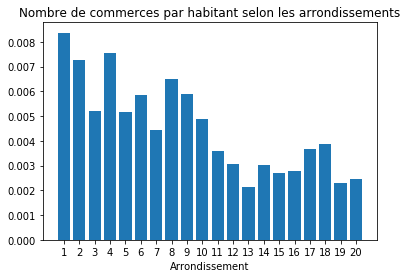

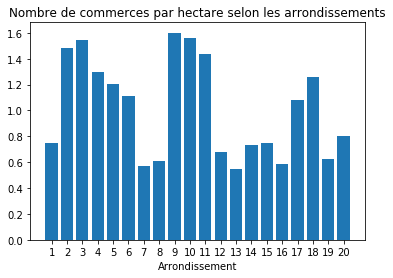

In [72]:
# Liste de la population par arrondissement

pop_par_ar = [
              16252,20260,34788,27487,59108,40916,52512,36453,59269,91932,
              147017,141494,181552,137105,233484,165446,167835,195060,186393,195604
             ]


df_com_arro = df_commerce['ARRO'].value_counts()
X = [str(i) for i in range(1,21)]
Y = [df_com_arro[i+1]/pop_par_ar[i] for i in range(20)]
plt.bar(X,Y)
plt.xlabel('Arrondissement')
plt.title('Nombre de commerces par habitant selon les arrondissements')
plt.show()

#On remarque que des arrondissements comme le 1er ou le 4ème ont beaucoup de commerces par habitant, au contraire du 13ème qui lui possède  une part de comemrces par habitant plus faible"""

#source INSEE, qu'on peut aussi lire ici https://www.apur.org/sites/default/files/documents/recueil_thematique_1234_arr_paris_0.pdf
#on se donne les surfaces des arrondissements en hectare

# Liste de la surface par arrondissement

surf_arrond =[182,99,117,160,254,215,409,388,218,289,367,639,715,562,850,790,567,600,679,598]
sum(surf_arrond)

Xs = [str(i) for i in range(1,21)]
Ys= [df_com_arro[i+1]/surf_arrond[i] for i in range(20)]

plt.bar(Xs,Ys)
plt.xlabel('Arrondissement')
plt.title('Nombre de commerces par hectare selon les arrondissements')
plt.show()

On a alors un problème : on ne peut pas construire un indice comme précedemment, car cela voudrait dire 
calculer la distance de chaque appartement à chaque commerce. Si cela a été possible pour les espaces verts, 
pour les stations de métro, cela semble beaucoup trop long pour les commerces, qui sont vraiment plus nombreux.  
Pour palier à ce problème, nous quadrillons Paris en 29 x 29 zones, nous calculons le nombre de commerces dans chaque zone, et on associe à chaque appartement le nombre de commerces de la zone où il se situe.

In [73]:
N = 29 # Taille du quadrillage

max_lon = max(df_commerce['lon'])
min_lon = min(df_commerce['lon'])
max_lat = 48.900391
min_lat = min(df_commerce['lat'])

linsplon = list(np.linspace(min_lon * (1 - 10 ** -7),max_lon*(1 + 10 ** -7), N))
linsplat = list(np.linspace(min_lat * (1 -10 ** -7),max_lat*(1 + 10 ** -7), N))

# Fonction qui renvoie l'indice de la première occurence de la liste 
# triée qui est strictement plus grande que l'argument x

def premier_plus_grand(L,x): 
    i=0
    
    while L[i]<= x:
        i+=1
        
    return i

def donne_zone(lat, lon, Linsplat, Linsplon):
  
    i = premier_plus_grand(Linsplat,lat)
    j = premier_plus_grand(Linsplon,lon)
    
    return i,j

zones_tout_commerce = np.zeros((N,N))
zones_commerce_luxe = np.zeros((N,N))

for k in range(len(df_commerce['lat'])):
    
    i,j = donne_zone(df_commerce['lat'][k], df_commerce['lon'][k], linsplat, linsplon)
    zones_tout_commerce[i][j] += 1
    
df_commerce_luxe = df_commerce[df_commerce['LIBACT'].isin(['Commerce détail de boissons', 
    'Charcuterie - Traiteur - Epicerie fine', 'Chocolaterie - Confiserie', 
    'Produits alimentaires bio et circuits courts', 'Crèmerie - Fromagerie', 
    'Torréfacteur - Commerce détail thé et café', 'Poisonnerie', 
    'Glacier : vente à emporter et consommation sur place', 'Alimentation générale de luxe > 300m²'
                                                            ]
                                                         )
                              ].reset_index(drop = True)
    
for k in range(len(df_commerce_luxe['lat'])):
    i,j = donne_zone(df_commerce_luxe['lat'][k], df_commerce_luxe['lon'][k], linsplat, linsplon)
    zones_commerce_luxe[i][j] += 1

def Zone_appart(lat,lon):
    i,j = donne_zone(lat,lon, linsplat, linsplon)
    return zones[i][j]

In [74]:
def calcule_scores_commerces(lat,lon):
    
    i,j = donne_zone(lat, lon, linsplat, linsplon)
    score_1, score_2 = zones_tout_commerce[i][j], zones_commerce_luxe[i][j]
    
    return score_1, score_2

In [75]:
# Calcul des scores

L1, L2 = [], []

for i, row in df.iterrows():
    (a,b) = calcule_scores_commerces(row.lat, row.lon)
    L1.append(a)
    L2.append(b)

In [76]:
# Integration à la base de données

df['score_commerce'], df['score_commerce_lux'] = L1, L2 

df['score_commerce'] /= max(df['score_commerce'])
df['score_commerce_lux'] /= max(df['score_commerce_lux'])

# Conclusion

In [77]:
df = df.drop(columns = {'Date','Valeur', 'Voie', 'Surface', 'TypeLocal', 'id', 'c_sec', 'n_pc'})
df.sample(5)

Numero TypeVoie  CodePostal  NbPieces     prixm2  periode_construction  \
16   207.0      RUE     75014.0       3.0   7.371795                   0.0   
76    80.0       AV     75016.0       4.0  11.778846                   2.0   
90    27.0      RUE     75020.0       2.0   9.489362                   3.0   
38    21.0      RUE     75006.0       1.0  10.976897                   3.0   
61    25.0      RUE     75003.0       1.0   9.300000                   2.0   

    Arrondissement       lon        lat  Quartier  score_jardin  \
16              14  2.307336  48.828527        56     32.398238   
76              16  2.271988  48.845959        61      5.530333   
90              20  2.384840  48.868016        77      5.132327   
38               6  2.337950  48.854988        21      2.809657   
61               3  2.358096  48.864766         9      4.185745   

    score_monument  score_metro  score_commerce  score_commerce_lux  
16        0.004844     0.093064        0.041237                0.00  
76        0.037362     0.051838        0.061856                0.10  
90        0.014338     0.089330        0.298969                0.10  
38        0.654987     0.098332        0.206186                0.55  
61        0.351851     0.275306        0.412371                0.70

**On obtient ici une base de données enrichie de plusieurs variables, qui pourra être exploitée par la suite.  
La suite au prochain notebook!**